<a href="https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/Swift4TF_DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import TensorFlow
import Python
import Foundation

In [0]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let plt = Python.import("matplotlib.pyplot")
let np  = Python.import("numpy")
let subprocess = Python.import("subprocess")
let glob = Python.import("glob")
let pil = Python.import("PIL")

## Download Weights

In [3]:
let command = "wget -nv -O- http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz | tar xzf - -C ."
subprocess.call(command, shell: true)

2019-05-18 00:44:58 URL:http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz [513324920/513324920] -> "-" [1]


0


## Download Input Image

In [4]:
let command = "wget https://storage.googleapis.com/applied-dl/clouds.jpg -O img.jpg"
subprocess.call(command, shell: true)

--2019-05-18 00:44:58--  https://storage.googleapis.com/applied-dl/clouds.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85266 (83K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  83.27K  --.-KB/s    in 0.001s  

2019-05-18 00:44:59 (97.1 MB/s) - ‘img.jpg’ saved [85266/85266]



0


(480, 598, 3)


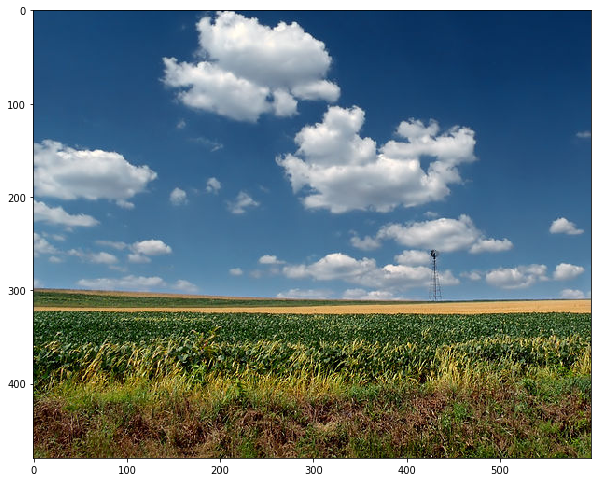

None


In [5]:
plt.rcParams["figure.figsize"] = [10, 14]

let img = pil.Image.open("img.jpg")
print(np.array(img).shape)
plt.imshow(np.array(img))
plt.show()

## Setup VGG 16 Model

In [0]:
func loadParameters<Scalar: FloatingPoint>(for tensorName: String) -> Tensor<Scalar> {
    let fullTensorName = StringTensor(["vgg_16/\(tensorName)"])
    return Raw.restoreV2(prefix: StringTensor("./vgg_16.ckpt"), 
              tensorNames: fullTensorName, 
              shapeAndSlices: StringTensor([""]), 
              dtypes: [Float.tensorFlowDataType])[0] as! Tensor<Scalar>
}
                         
public extension Conv2D where Scalar: FloatingPoint {
    init(named name: String) {
        self.init(filter: loadParameters(for: "\(name)/weights"),
                  bias: loadParameters(for: "\(name)/biases"), 
                  activation: relu,
                  strides: (1, 1),
                  padding: .same)
    }
}

In [0]:
struct VGG16: Layer {
    var conv1a: Conv2D<Float>
    var conv1b: Conv2D<Float>
    
    var conv2a: Conv2D<Float>
    var conv2b: Conv2D<Float>
    
    var conv3a: Conv2D<Float>
    var conv3b: Conv2D<Float>
    var conv3c: Conv2D<Float>
    
    var conv4a: Conv2D<Float>
    var conv4b: Conv2D<Float>
    var conv4c: Conv2D<Float>
    
    var conv5a: Conv2D<Float>
    var conv5b: Conv2D<Float>
    var conv5c: Conv2D<Float>
    
    var pool: MaxPool2D<Float>
    
    var flatten: Flatten<Float>
  
    init() {
        
        // Layer 1        
        self.conv1a = Conv2D(named: "conv1/conv1_1")
        self.conv1b = Conv2D(named: "conv1/conv1_2")
        
        // Layer 2
        self.conv2a = Conv2D(named: "conv2/conv2_1")
        self.conv2b = Conv2D(named: "conv2/conv2_2")
        
        // Layer 3
        self.conv3a = Conv2D(named: "conv3/conv3_1")
        self.conv3b = Conv2D(named: "conv3/conv3_2")
        self.conv3c = Conv2D(named: "conv3/conv3_3")
        
        // Layer 4
        self.conv4a = Conv2D(named: "conv4/conv4_1")
        self.conv4b = Conv2D(named: "conv4/conv4_2")
        self.conv4c = Conv2D(named: "conv4/conv4_3")
        
        // Layer 5
        self.conv5a = Conv2D(named: "conv5/conv5_1")
        self.conv5b = Conv2D(named: "conv5/conv5_2")
        self.conv5c = Conv2D(named: "conv5/conv5_3")
        self.pool   = MaxPool2D(poolSize:(2,2), strides: (2,2))
        self.flatten = Flatten<Float>()
    }
    
    @differentiable
    func call(_ input: Tensor<Float>) -> Tensor<Float> {
        var x = input
        
        // Layer 1
        x = conv1a(x)
        x = conv1b(x)
        x = pool(x)
        
        // Layer 2 
        x = conv2a(x)
        x = conv2b(x)
        x = pool(x)
        
        // Layer 3
        x = conv3a(x)
        x = conv3b(x)
        x = conv3c(x)
        x = pool(x)
        
        // Layer 4
        x = conv4a(x)
        x = conv4b(x)
        x = conv4c(x)
        x = pool(x)
        
        // Layer 5
        x = conv5a(x)
        x = conv5b(x)
        x = conv5c(x)
        x = pool(x)
        return x
    }
}

In [8]:
var vgg = VGG16()
print(vgg(Tensor<Float>(zeros: [1, 224, 224, 3])).shape)

[1, 7, 7, 512]


## Helper functions

In [0]:
func preprocess(_ img:PythonObject) -> Tensor<Float>{
  let image = Tensor<UInt8>(numpy: np.array(img))!
  var tensor = Tensor<Float>(image)
  tensor = Raw.expandDims(tensor, dim: Tensor<Int32>(0))
  tensor = Raw.resizeArea(images:tensor , size:[224, 224] )
  tensor = tensor / 255
  return tensor
}

func deprocess(_ tensor:Tensor<Float>) -> PythonObject{
  var img = tensor * 255
  img = Raw.clipByValue(t: img, clipValueMin: Tensor<Float>(0) , clipValueMax: Tensor<Float>(255))
  img = img.squeezingShape()
  return img.makeNumpyArray().astype("uint8")
}

## Deep Dream Procedure

In [0]:
func deepDream(at indx:Int){
  
  var tensor = preprocess(img)
  let iter = 100 

  for i in 1...iter{
    
    //evaluate the gradient with repsect to the current image 
    var (loss, grads) = valueWithGradient(at: tensor) { tensor -> Tensor<Float> in
      let out = vgg(tensor)

      //hacky approach to find the gradient with resepect to a certain activation 
      //we set the index of the activations as ones so that the gradient can flow in the at direction                                                  
      let bef = Tensor<Float>(zeros:[1, 7, 7, indx])                                                
      let mid = Tensor<Float>(ones: [1, 7, 7, 1])                                                 
      let aft = Tensor<Float>(zeros: [1, 7, 7, 511-indx]) 

      let act = out * Raw.concat(concatDim: Tensor<Int32>(3), [bef,mid, aft])
      return act.mean()
    }
    
    //normalize 
    grads /= (grads.max()) + 1e-8 
    grads /= 50.0
    
    //update the imag etensor
    tensor = tensor + grads
  }
  
  //plot the final output
  plt.imshow(deprocess(tensor))
  plt.show()
}

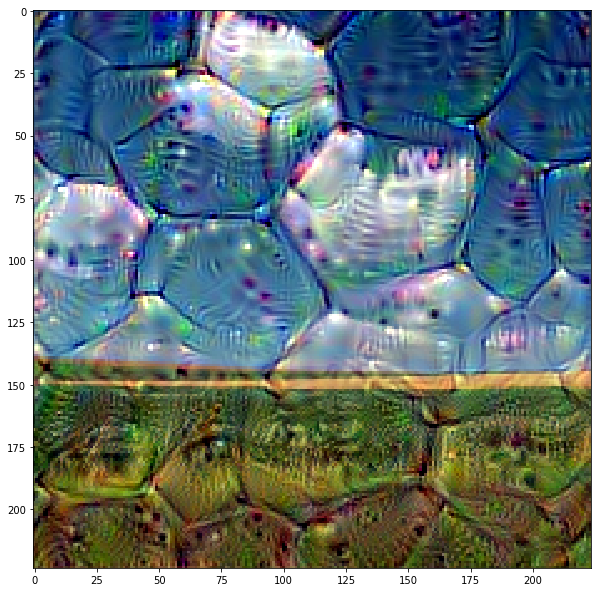

In [11]:
//choose between 0-512
deepDream(at: 0)